In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix
import multiprocessing as mp
import shutil
from tensorflow.keras import applications
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *

import pandas as pd
import numpy as np
import seaborn as sn

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
warnings.filterwarnings("ignore")
%matplotlib inline

Mounted at /content/drive


In [ ]:
epochs = 100
batch_size = 32
#testsplit = .2
targetx = 150
targety = 150
learning_rate = 0.0001
classes = 4
seed = random.randint(1, 1000)
data_dir = "/content/drive/MyDrive/Cabbage_Dataset/training"
data_dir1 = "/content/drive/MyDrive/Cabbage_Dataset/validation"

In [ ]:
datagen = ImageDataGenerator(
        shear_range=0.1,
        #rescale=1./255,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed

)

validation_generator = datagen.flow_from_directory(
        data_dir1,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed
)

Found 980 images belonging to 4 classes.
Found 212 images belonging to 4 classes.


In [ ]:
checkpoint = ModelCheckpoint('EfficientNetB7.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             period=1)

#tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                           # histogram_freq=0,
                            #batch_size=batch_size,
                            #write_graph=False,
                            #update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(model.optimizer.lr))

def train_begin(logs):
    os.system("echo Beginning training")

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=.0001,
                          patience=50,
                          verbose=1,
                          mode='auto',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=5,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-l0j3rcsl
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/efficientnet /tmp/pip-req-build-l0j3rcsl
  Resolved https://github.com/qubvel/efficientnet to commit f7f3e736c113b872caf53dae9fbbda996a8eb87d
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18430 sha256=5cacbbd650d51f93bcccf5e5cd550b1014c78d5f75249cc36b144f25bf5663b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-a5t6kzit/wheels/bb/0f/38/154505705a0899276d49f521ee621a61bc2a8767026220f751
Successfully built efficientnet


In [ ]:

import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
import efficientnet.keras as enet

In [ ]:

model = enet.EfficientNetB7(include_top=False, input_shape=(150,150,3), pooling='avg', weights='imagenet')
#model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(32,32,3), pooling='avg', weights='imagenet')

# Adding 2 fully-connected layers to B0.
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(5120)(x)
x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(1280)(x)
x = BatchNormalization()(x)
x = Dropout(0.7)(x)

# Output layer
predictions = Dense(4, activation="softmax")(x)

model = Model(inputs = model.input, outputs = predictions)

#model_final.summary()
optimizer = Adam(lr=learning_rate)
loss = "categorical_crossentropy"



model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])



258434480/258434480 [==============================] - 2s 0us/step


In [ ]:
t=time.time()
history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=len(train_generator),
                                validation_data=validation_generator,
                                validation_steps=len(validation_generator),
                                epochs=epochs,
                                callbacks=[reducelr])

#compute the training time
print('Training time: %s' % (time.time()-t))

Epoch 1/100
31/31 [==============================] - 343s 9s/step - loss: 3.0017 - accuracy: 0.3204 - val_loss: 1.3259 - val_accuracy: 0.3208 - lr: 1.0000e-04
Epoch 2/100
31/31 [==============================] - 36s 1s/step - loss: 2.4075 - accuracy: 0.3939 - val_loss: 1.1903 - val_accuracy: 0.4198 - lr: 1.0000e-04
Epoch 3/100
31/31 [==============================] - 27s 875ms/step - loss: 1.8541 - accuracy: 0.5439 - val_loss: 0.9702 - val_accuracy: 0.5802 - lr: 1.0000e-04
Epoch 4/100
31/31 [==============================] - 28s 890ms/step - loss: 1.2632 - accuracy: 0.6663 - val_loss: 0.6641 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 5/100
31/31 [==============================] - 28s 889ms/step - loss: 0.8803 - accuracy: 0.7480 - val_loss: 0.4334 - val_accuracy: 0.8491 - lr: 1.0000e-04
Epoch 6/100
31/31 [==============================] - 28s 902ms/step - loss: 0.6661 - accuracy: 0.8316 - val_loss: 0.2413 - val_accuracy: 0.9387 - lr: 1.0000e-04
Epoch 7/100
31/31 [====================

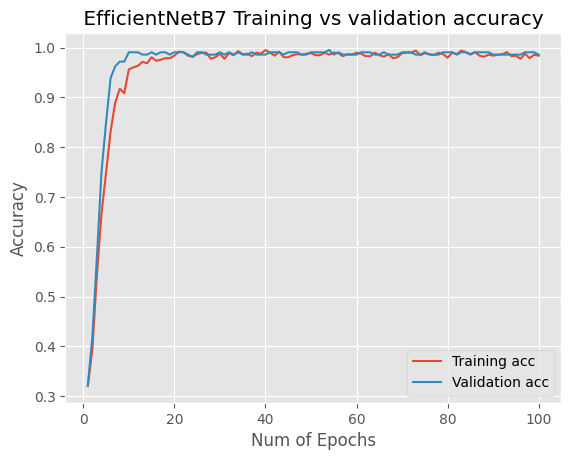

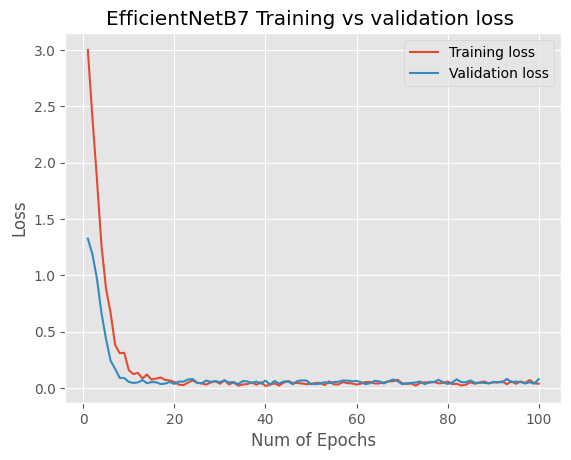

In [ ]:
import matplotlib.pyplot as plt
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.style.use('ggplot')

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.xlabel('Num of Epochs')
plt.ylabel('Accuracy')
plt.title(' EfficientNetB7 Training vs validation accuracy ')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('EfficientNetB7 Training vs validation loss ')
plt.xlabel('Num of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
accuracy = np.array(acc)
print(' Training Accuracy of model is      :   '  , accuracy[-1]*100,'%' )

val_accuracy = np.array(val_acc)
print('  Validation  Accuracy of model is      :   '  , val_accuracy[-1]*100,'%' )

t_loss = np.array(loss)
print('training   loss of   model   is     :   ' , t_loss[-1]*100,'%')
val_loss = np.array(val_loss)
print('Validation  loss of   model  is     :   ' , val_loss[-1]*100,'%')

 Training Accuracy of model is      :    98.36734533309937 %
  Validation  Accuracy of model is      :    98.58490824699402 %
training   loss of   model   is     :    3.6766543984413147 %
Validation  loss of   model  is     :    7.834982126951218 %


In [ ]:
data_dir1 = "/content/drive/MyDrive/Cabbage_Dataset/testing"

datagen = ImageDataGenerator(
        shear_range=0.1,
        zoom_range=0.1,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        preprocessing_function=preprocess_input
)
val_suffle=False

test_generator = datagen.flow_from_directory(
        data_dir1,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False,

        #subset="test"
)
score = model.evaluate_generator(test_generator, verbose=1)
print(score)

Found 208 images belonging to 4 classes.
7/7 [==============================] - 7s 647ms/step - loss: 0.0530 - accuracy: 0.9856
[0.05299625173211098, 0.9855769276618958]


In [ ]:
import matplotlib.pyplot as plt


ptest_accuracy = 99.1
atest_accuracy = 98.2
vtest_accuracy = 97.1
gtest_accuracy = 98.7
plt.style.use('ggplot')

accuracys = [ptest_accuracy, atest_accuracy, vtest_accuracy, gtest_accuracy]
tick_labels = ["proposed", "AlexNet", "VGG16", "GoogleNet"]
plt.bar(range(4), accuracys)
plt.xlabel('Receiver Operating characteristic(ROC)')
plt.ylabel('Average ROC Under Curve Area in %')
plt.xticks(range(4), tick_labels)
for x_,y_ in zip(range(4), accuracys):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)

In [ ]:
import matplotlib.pyplot as plt


ptest_accuracy = 96.21
atest_accuracy = 87.50
vtest_accuracy = 87.88
gtest_accuracy = 90.15
plt.style.use('fivethirtyeight')

accuracys = [ptest_accuracy, atest_accuracy, vtest_accuracy, gtest_accuracy]
tick_labels = ["proposed", "AlexNet", "VGG16", "GoogleNet"]
plt.bar(range(4), accuracys)
plt.xlabel('Accuracy')
plt.ylabel('accuracy in %')
plt.xticks(range(4), tick_labels)
for x_,y_ in zip(range(4), accuracys):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)

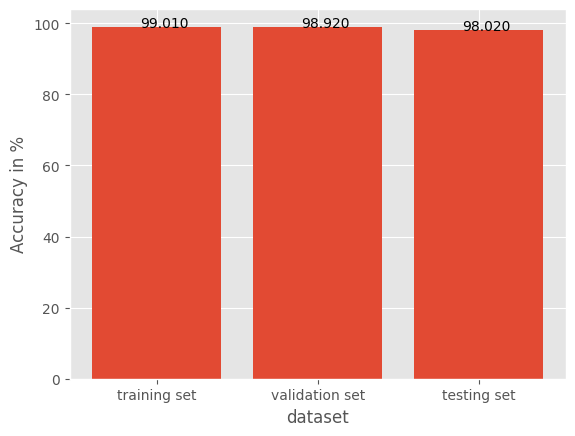

In [22]:
import matplotlib.pyplot as plt

train_accuracy = 99.01
valid_accuracy =98.92
test_accuracy = 98.02
plt.style.use('ggplot')

accuracys = [train_accuracy, valid_accuracy, test_accuracy]
tick_labels = ["training set", "validation set", "testing set"]
plt.bar(range(3), accuracys)
plt.xlabel('dataset')
plt.ylabel('Accuracy in %')
plt.xticks(range(3), tick_labels)
for x_,y_ in zip(range(3), accuracys):
    plt.text(x_ - 0.1, y_, '%.3f'%y_)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve,auc
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sn
def plot_multiclass_roc(y_pred, y_test, n_classes,class_label, figsize=(17, 6)):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i,j in enumerate(class_label):
        print(i,j)
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = {}) for label {}'.format(np.round(roc_auc[i],2),j))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

6/6 [==============================] - 11s 810ms/step
0 Cabbage_Aphid
1 Cabbage_Black_Rot
2 Cabbage_Healthy
3 Cabbage_Worm_Cut


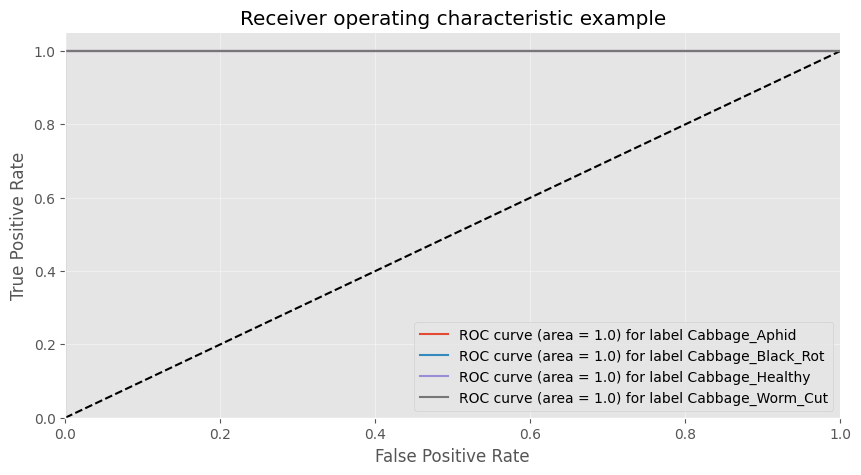

In [ ]:
#Alexnet_model.evaluate(valid_set,steps=valid_set.n//batch_size)
#valid_set.reset()

model.evaluate(test_generator,steps=test_generator.n//batch_size)
test_generator.reset()

y_pred=model.predict(test_generator,steps=test_generator.n/batch_size,verbose=1)
class_label=list(test_generator.class_indices.keys())


if val_suffle==True:
  per = np.random.permutation(test_generator.n)
  test_generator.index_array = per
  y_true = test_generator.classes[per]
else:
  y_true = test_generator.classes


plot_multiclass_roc( y_pred, pd.get_dummies(y_true), n_classes=4,class_label=class_label, figsize=(10, 5))

In [ ]:
score = model.evaluate_generator(test_generator, verbose=1)

In [ ]:
test_generator.reset()
predictions = model.predict_generator(test_generator, steps=len(test_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=test_generator.classes, y_pred=y, target_names=test_generator.class_indices)
print(cr)

Classification Report
                   precision    recall  f1-score   support

    Cabbage_Aphid       1.00      1.00      1.00        52
Cabbage_Black_Rot       1.00      0.98      0.99        52
  Cabbage_Healthy       1.00      0.96      0.98        52
 Cabbage_Worm_Cut       0.95      1.00      0.97        52

         accuracy                           0.99       208
        macro avg       0.99      0.99      0.99       208
     weighted avg       0.99      0.99      0.99       208



7/7 [==============================] - 5s 650ms/step


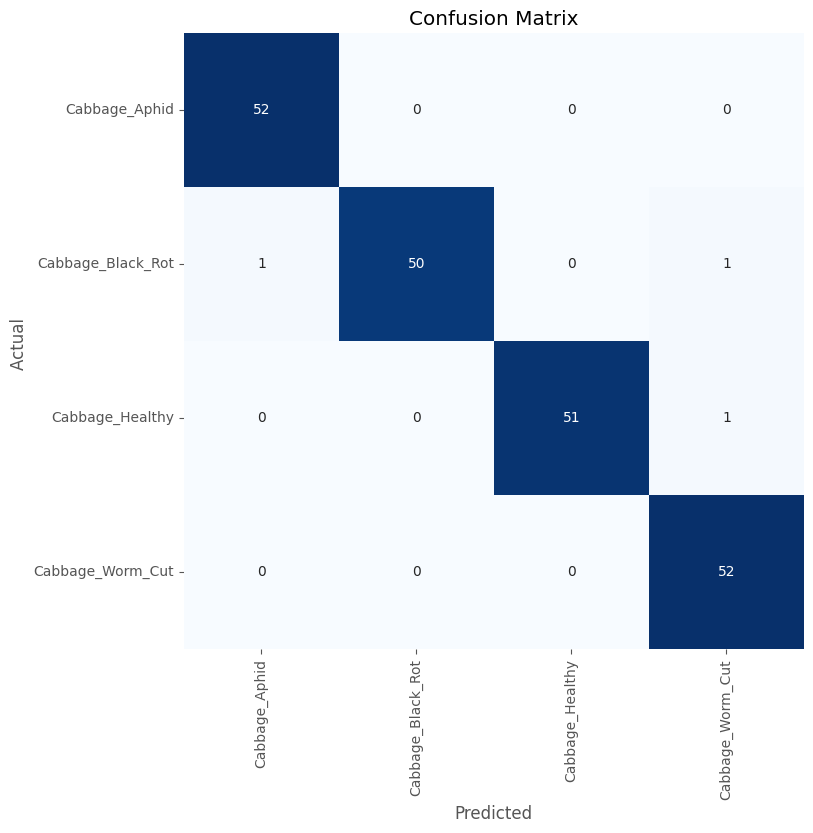

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
classes=['Cabbage_Aphid', 'Cabbage_Black_Rot', 'Cabbage_Healthy','Cabbage_Worm_Cut']

preds=model.predict(test_generator)
y_pred=[]
y_true=[]
for i, p in enumerate(preds):
    y_pred.append(np.argmax(p))
    y_true.append(test_generator.labels[i])
y_pred=np.array(y_pred)
y_true=np.array(y_true)
cm = confusion_matrix(y_true, y_pred )
clr = classification_report(y_true, y_pred, target_names=classes)
length=len(classes)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(length)+.5, classes, rotation= 90)
plt.yticks(np.arange(length)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual ")
plt.title("Confusion Matrix")
plt.show()